In [381]:
%matplotlib inline
from joblib import dump
import os
from scipy.io import loadmat
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn import metrics
from collections import defaultdict
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
import sys
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [464]:
x = loadmat('../data/pima.mat')

In [384]:
def generate_sample_w_replacement(size, n_splits, ratio=1/np.exp(0)):
    idx=0
    splits=[]
    while idx < n_splits:
        sample = np.random.choice(range(0, size), size=int(size*(1/np.exp(0))))
        test = list(set(range(0, size)).difference(sample))
        splits.append((sample, np.array(test)))
        idx+=1
        
    return splits
    

## Logistic Regression classifier

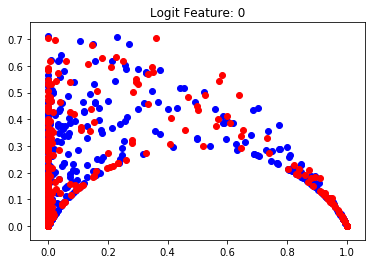

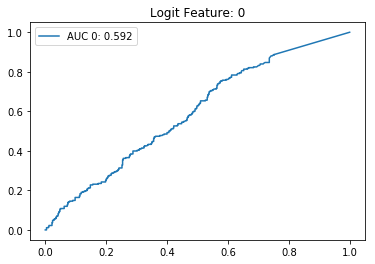

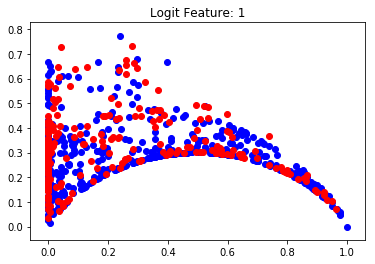

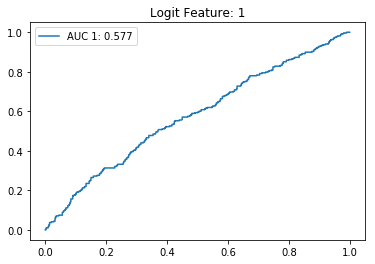

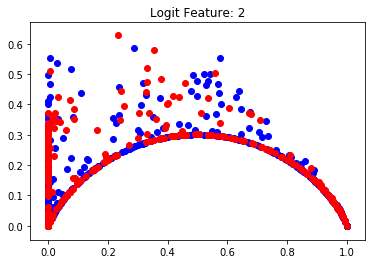

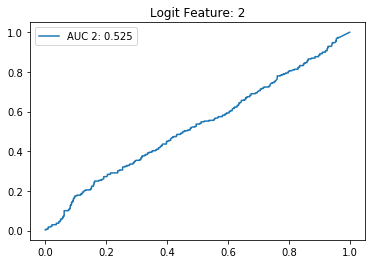

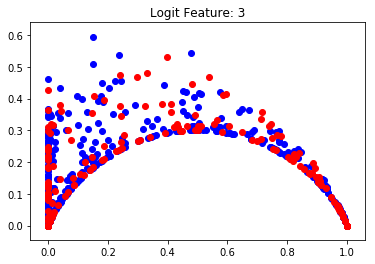

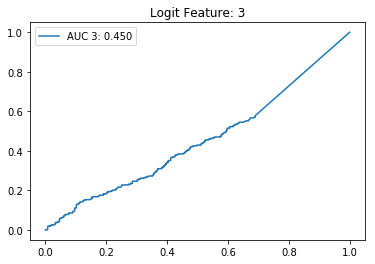

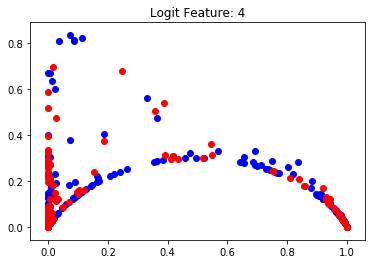

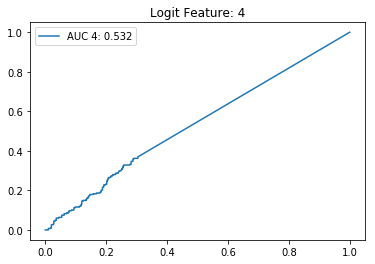

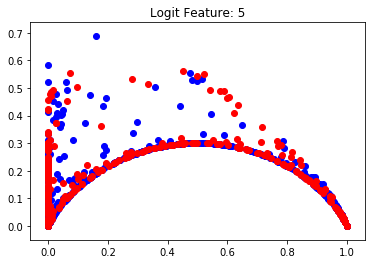

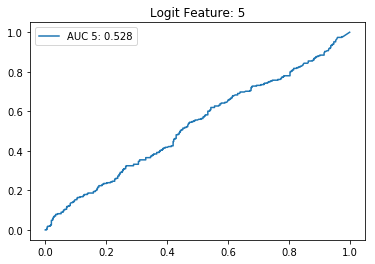

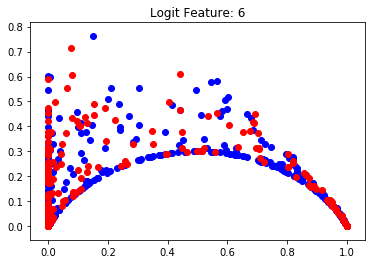

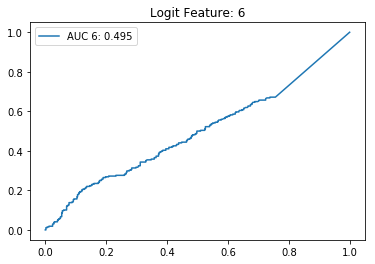

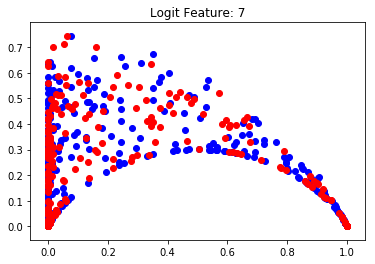

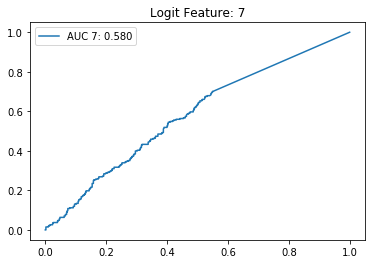

In [397]:
labels=x['y'].flatten()
number_of_models = 500
model_type="Logit"
# Logitic Regression bootstrapping
results_pd=pd.DataFrame()
metrics_pd=pd.DataFrame()
auc_dict={}

for feature_index in range(x['X'].shape[1]):
    target=x['X'][:, feature_index]
    copy=x['X']
    data=np.delete(copy, [feature_index], axis=1)
    
    bins=10
    target = np.digitize(target, bins=np.histogram(target, bins=bins)[1])
    outcomes=defaultdict()
    for key in range(data.shape[0]):
        outcomes[key]=list() 
    rkf = generate_sample_w_replacement(labels.shape[0], number_of_models)
    for train, test in rkf:

        clf = LogisticRegression(random_state=0, solver='lbfgs',
                                 multi_class='multinomial').fit(data[train], target[train])

        decision=clf.predict(data[test]) 
        for number, idx in enumerate(test):
            outcomes[idx].append(decision[number])
    
    
    prob=[[outcomes[key].count(value)/float(len(outcomes[key])) for value in range(1, max(np.unique(target))+1)]
          for key in range(data.shape[0])]

    num_classes=np.unique(y).shape[0]
    if num_classes>1:
        max_entropy = np.log(num_classes)
    else:
        max_entropy = 1
        
    entropy = np.array([sum([-value*np.log(value+10**(-8)) for value in ls]) for ls in prob])/max_entropy
    
    corresponding_prob = np.array([np.array(prob)[idx][[value-1]] for idx, value in enumerate(target)]).flatten()

    plt.scatter(corresponding_prob[labels==0], 
                entropy[labels==0], color='b')         

    plt.scatter(corresponding_prob[labels==1], 
                entropy[labels==1], color='r')

    fpr, tpr, thresholds = metrics.roc_curve(labels, entropy, pos_label=1)
    metrics_pd["fpr_{}".format(feature_index)] = pd.Series(fpr)
    metrics_pd["tpr_{}".format(feature_index)] = pd.Series(tpr)
    
    auc=metrics.auc(fpr, tpr)
    auc_dict[feature_index] = auc
    
    plt.title("{} Feature: {}".format(model_type, feature_index))
    plt.show()
    plt.plot(fpr, tpr, label="AUC {}: {:.3f}".format(feature_index, auc))
    plt.legend()
    plt.title("{} Feature: {}".format(model_type, feature_index))
    plt.show()

    results_pd["entropy_{}".format(feature_index)]=pd.Series(entropy)

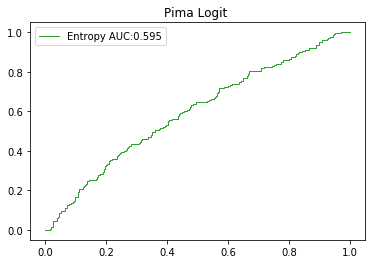

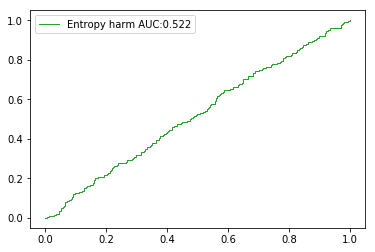

In [398]:
columns_list_entropy=["entropy_{}".format(index) for index in range(x['X'].shape[1])]
plt.title("Pima {} ".format(model_type))
results_pd['entropy_sum']=(results_pd[columns_list_entropy]).sum(axis=1)/x['X'].shape[1]

abs_diff_harmonic=results_pd[columns_list_entropy].apply(np.log).sum(skipna=True, axis=1).replace(-np.inf, -1000).replace(np.inf, 1000)
results_pd['entropy_agg_harmonic_sum']=pd.Series(minmax_scale(abs_diff_harmonic.values))
fpr, tpr, thresholds = metrics.roc_curve(labels, results_pd['entropy_sum'], pos_label=1)
plt.plot(fpr, tpr, lw=1, label="Entropy AUC:{:.3}".format(metrics.auc(fpr, tpr)), color='C{}'.format(2))
plt.legend()
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(labels, results_pd['entropy_agg_harmonic_sum'], pos_label=1)
plt.plot(fpr, tpr, lw=1, label="Entropy harm AUC:{:.3}".format(metrics.auc(fpr, tpr)), color='C{}'.format(2))
plt.legend()
plt.show()

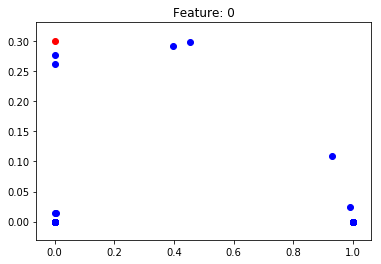

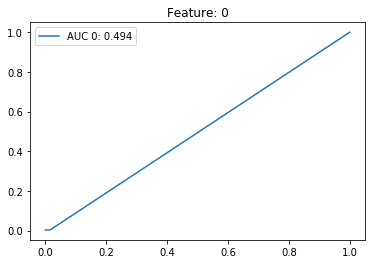

10


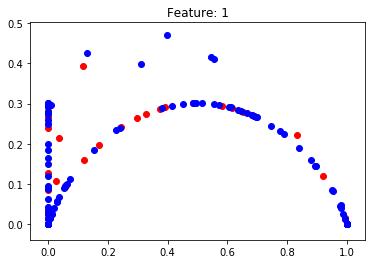

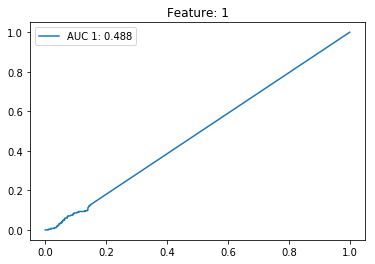

10


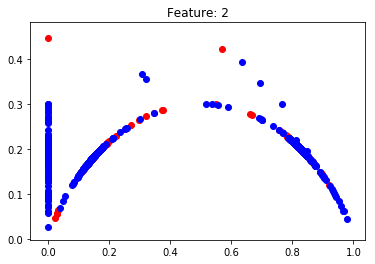

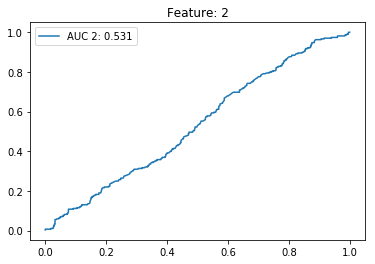

10


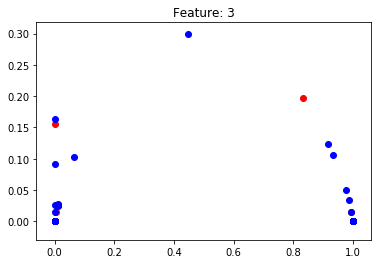

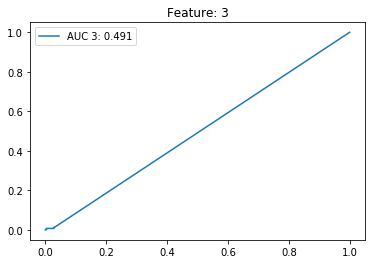

10


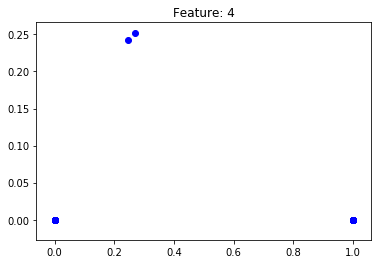

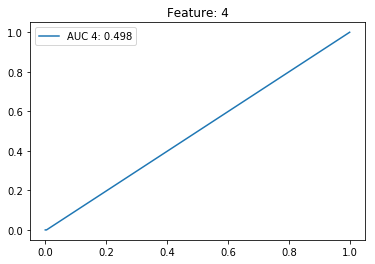

10


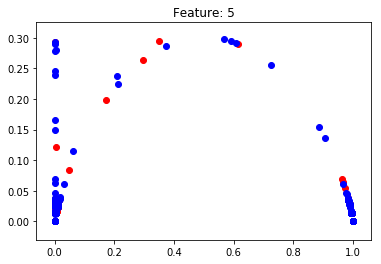

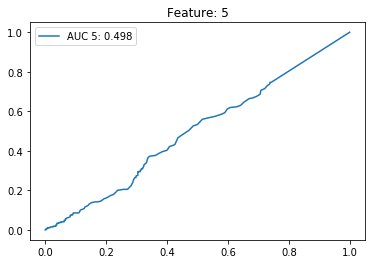

10


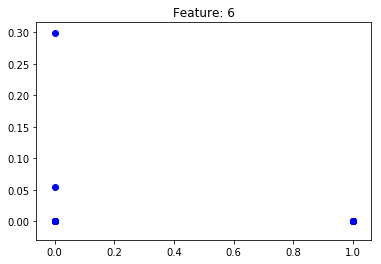

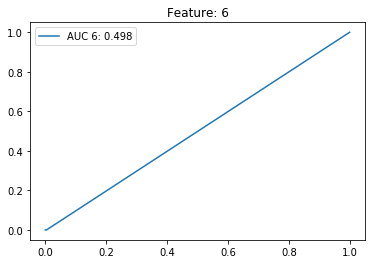

10


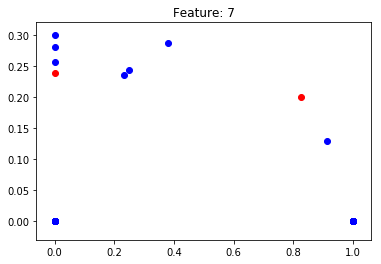

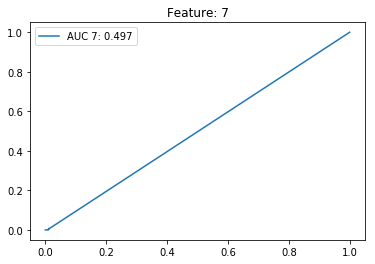

10


In [402]:
# SVC bootstrapping
labels=x['y'].flatten()
number_of_models = 500
model_type="SVM"

results_pd=pd.DataFrame()
metrics_pd=pd.DataFrame()
auc_dict={}
for feature_index in range(x['X'].shape[1]):
#for feature_index in [0]:
    target=x['X'][:, feature_index]
    copy=x['X']
    data=np.delete(copy, [feature_index], axis=1)
    
    bins=10
    target = np.digitize(target, bins=np.histogram(target, bins=bins)[1])
    y_map={value: list(set(target.flatten())).index(value)  for value in set(target.flatten())}
    outcomes=defaultdict()
    for key in range(data.shape[0]):
        outcomes[key]=list() 
    rkf = generate_sample_w_replacement(labels.shape[0], number_of_models)
    for train, test in rkf:

        clf = svm.SVC().fit(data[train], target[train])

        decision=clf.predict(data[test]) 
        for number, idx in enumerate(test):
            outcomes[idx].append(decision[number])
    
    
    prob=[[outcomes[key].count(value)/float(len(outcomes[key])) for value in range(1, max(np.unique(target))+1)]
          for key in range(data.shape[0])]

    num_classes=np.unique(y).shape[0]
    if num_classes>1:
        max_entropy = np.log(num_classes)
    else:
        max_entropy = 1
        
    entropy = np.array([sum([-value*np.log(value+10**(-8)) for value in ls]) for ls in prob])/max_entropy

    corresponding_prob = np.array([np.array(prob)[idx][[value-1]] for idx, value in enumerate(target)]).flatten()

           

    plt.scatter(corresponding_prob[labels==1], 
                entropy[labels==1], color='r')

    plt.scatter(corresponding_prob[labels==0], 
                entropy[labels==0], color='b')

    fpr, tpr, thresholds = metrics.roc_curve(labels, entropy, pos_label=1)
    metrics_pd["fpr_{}".format(feature_index)] = pd.Series(fpr)
    metrics_pd["tpr_{}".format(feature_index)] = pd.Series(tpr)
    
    auc=metrics.auc(fpr, tpr)
    auc_dict[feature_index] = auc
    
    plt.title("Feature: {}".format(feature_index))
    plt.show()
    plt.plot(fpr, tpr, label="AUC {}: {:.3f}".format(feature_index, auc))
    plt.legend()
    plt.title("Feature: {}".format(feature_index))
    plt.show()
    results_pd["entropy_{}".format(feature_index)]=pd.Series(entropy)
    print num_classes

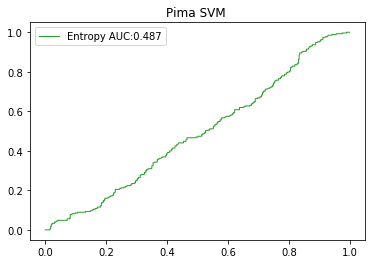

In [403]:
columns_list_entropy=["entropy_{}".format(index) for index in range(x['X'].shape[1])]

results_pd['entropy_sum']=(results_pd[columns_list_entropy]).sum(axis=1)/x['X'].shape[1]

fpr, tpr, thresholds = metrics.roc_curve(labels, results_pd['entropy_sum'], pos_label=1)
plt.title("Pima {} ".format(model_type))
plt.plot(fpr, tpr, lw=1, label="Entropy AUC:{:.3}".format(metrics.auc(fpr, tpr)), color='C{}'.format(2))
plt.legend()

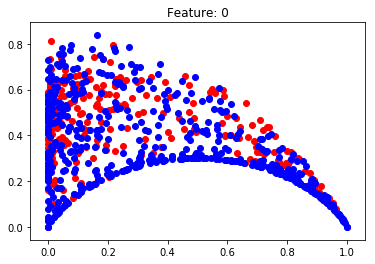

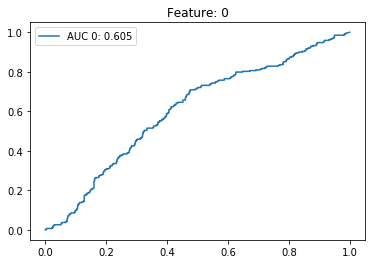

10


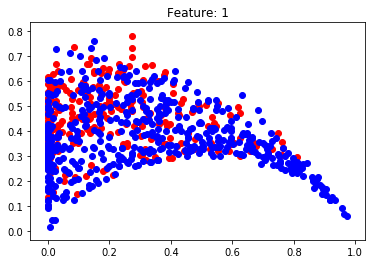

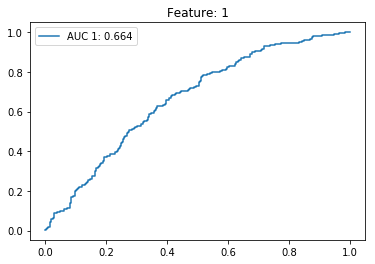

10


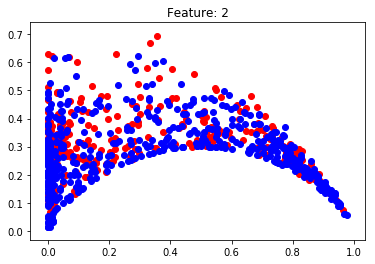

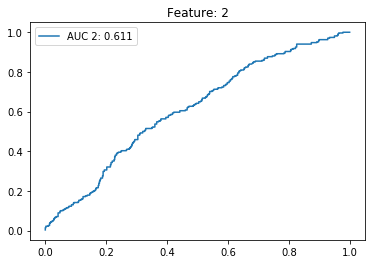

10


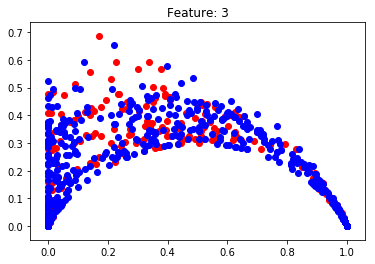

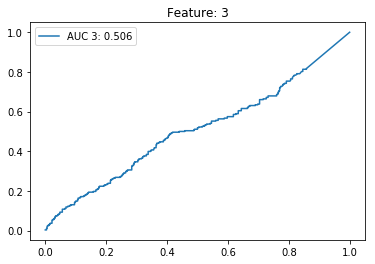

10


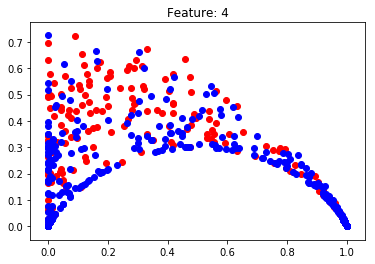

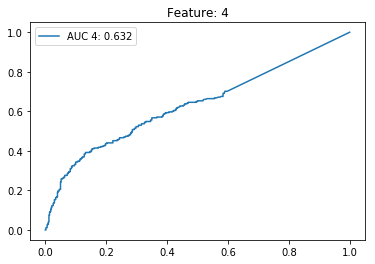

10


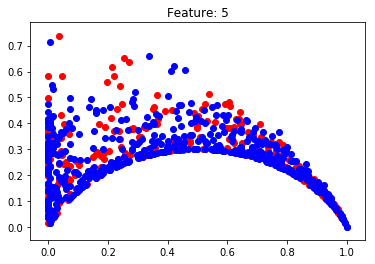

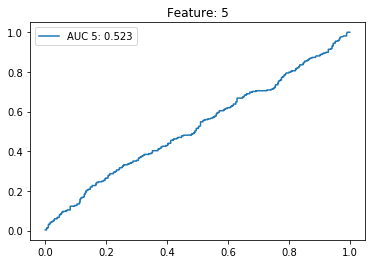

10


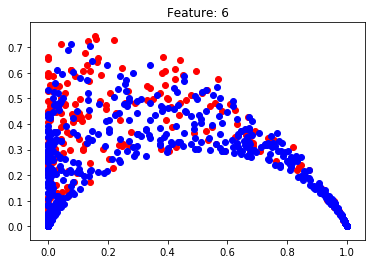

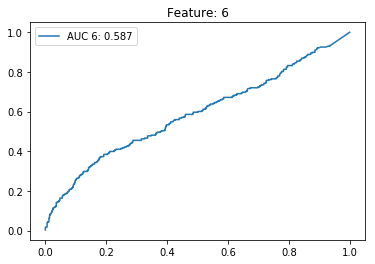

10


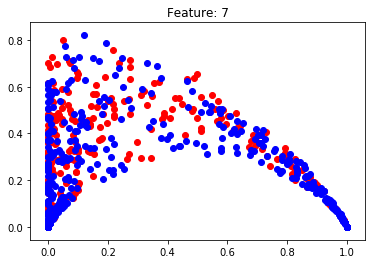

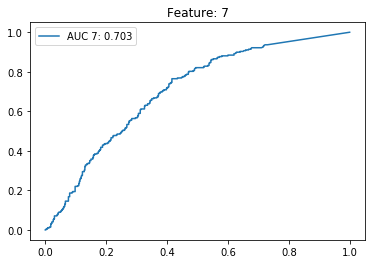

10


In [405]:
labels=x['y'].flatten()
number_of_models = 500
model_type="GradientBoosting"

results_pd=pd.DataFrame()
metrics_pd=pd.DataFrame()
auc_dict={}
for feature_index in range(x['X'].shape[1]):
#for feature_index in [0]:
    target=x['X'][:, feature_index]
    copy=x['X']
    data=np.delete(copy, [feature_index], axis=1)
    
    bins=10
    target = np.digitize(target, bins=np.histogram(target, bins=bins)[1])
    y_map={value: list(set(target.flatten())).index(value)  for value in set(target.flatten())}
    outcomes=defaultdict()
    for key in range(data.shape[0]):
        outcomes[key]=list() 
    rkf = generate_sample_w_replacement(labels.shape[0], number_of_models)
    for train, test in rkf:

        clf = GradientBoostingClassifier(n_estimators=10).fit(data[train], target[train])

        decision=clf.predict(data[test]) 
        for number, idx in enumerate(test):
            outcomes[idx].append(decision[number])
    
    
    prob=[[outcomes[key].count(value)/float(len(outcomes[key])) for value in range(1, max(np.unique(target))+1)]
          for key in range(data.shape[0])]

    num_classes=np.unique(y).shape[0]
    if num_classes>1:
        max_entropy = np.log(num_classes)
    else:
        max_entropy = 1
        
    entropy = np.array([sum([-value*np.log(value+10**(-8)) for value in ls]) for ls in prob])/max_entropy

    corresponding_prob = np.array([np.array(prob)[idx][[value-1]] for idx, value in enumerate(target)]).flatten()

           

    plt.scatter(corresponding_prob[labels==1], 
                entropy[labels==1], color='r')

    plt.scatter(corresponding_prob[labels==0], 
                entropy[labels==0], color='b')

    fpr, tpr, thresholds = metrics.roc_curve(labels, entropy, pos_label=1)
    metrics_pd["fpr_{}".format(feature_index)] = pd.Series(fpr)
    metrics_pd["tpr_{}".format(feature_index)] = pd.Series(tpr)
    
    auc=metrics.auc(fpr, tpr)
    auc_dict[feature_index] = auc
    
    plt.title("Feature: {}".format(feature_index))
    plt.show()
    plt.plot(fpr, tpr, label="AUC {}: {:.3f}".format(feature_index, auc))
    plt.legend()
    plt.title("Feature: {}".format(feature_index))
    plt.show()
    print num_classes
    results_pd["entropy_{}".format(feature_index)]=pd.Series(entropy)
    results_pd["prob_{}".format(feature_index)]=pd.Series(corresponding_prob)

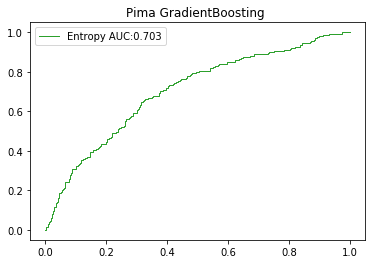

In [401]:
columns_list_entropy=["entropy_{}".format(index) for index in range(x['X'].shape[1])]

results_pd['entropy_sum']=(results_pd[columns_list_entropy]).sum(axis=1)/x['X'].shape[1]

fpr, tpr, thresholds = metrics.roc_curve(labels, results_pd['entropy_sum'], pos_label=1)
plt.title("Pima {} ".format(model_type))
plt.plot(fpr, tpr, lw=1, label="Entropy AUC:{:.3}".format(metrics.auc(fpr, tpr)), color='C{}'.format(2))
plt.legend()

In [20]:
from sklearn.ensemble import IsolationForest

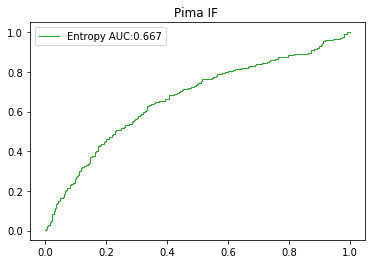

In [47]:
IF = IsolationForest(n_jobs=-1, max_samples=0.9, bootstrap=True)
if_pred=IF.fit(data)
fpr, tpr, thresholds =  metrics.roc_curve(x['y'].flatten(), -(IF.decision_function(x['X'])+0.5), pos_label=1)

plt.title("Pima IF ")
plt.plot(fpr, tpr, lw=1, label="Entropy AUC:{:.3}".format(metrics.auc(fpr, tpr)), color='C{}'.format(2))
plt.legend()

In [279]:
from sklearn.ensemble import IsolationForest

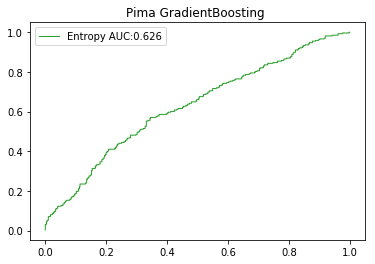

In [330]:
IF = IsolationForest(n_jobs=-1, max_samples=0.9)
if_pred=IF.fit(data_pd)
fpr, tpr, thresholds = metrics.roc_curve(labels, if_pred.decision_function(data_pd)*(-1), pos_label=1)
plt.title("Pima {} ".format(model_type))
plt.plot(fpr, tpr, lw=1, label="Entropy AUC:{:.3}".format(metrics.auc(fpr, tpr)), color='C{}'.format(2))
plt.legend()

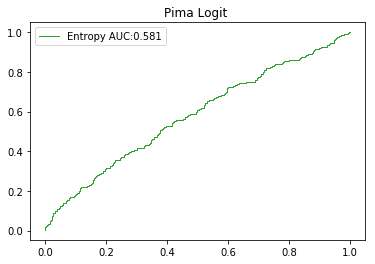

In [392]:
columns_list_entropy=["entropy_{}".format(index) for index in range(x['X'].shape[1])]

results_pd['entropy_sum']=(results_pd[columns_list_entropy]).sum(axis=1)/x['X'].shape[1]

fpr, tpr, thresholds = metrics.roc_curve(labels, results_pd['entropy_sum'], pos_label=1)
plt.title("Pima {} ".format(model_type))
plt.plot(fpr, tpr, lw=1, label="Entropy AUC:{:.3}".format(metrics.auc(fpr, tpr)), color='C{}'.format(2))
plt.legend()

## Decision Trees

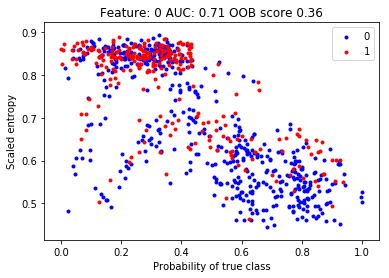

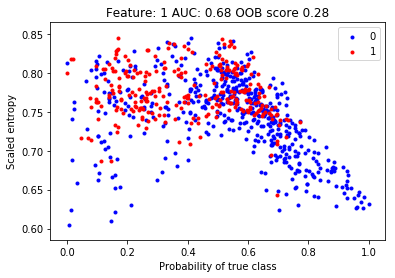

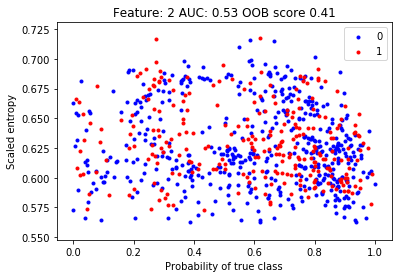

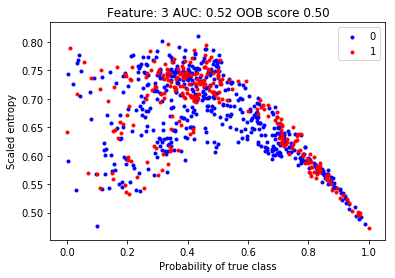

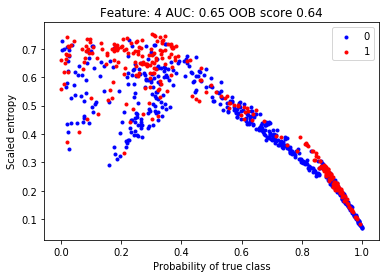

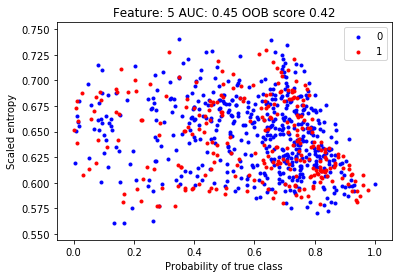

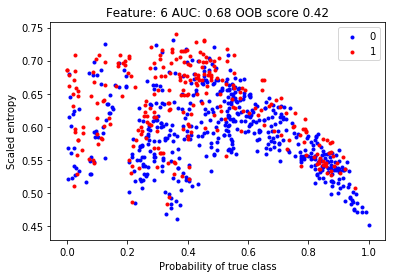

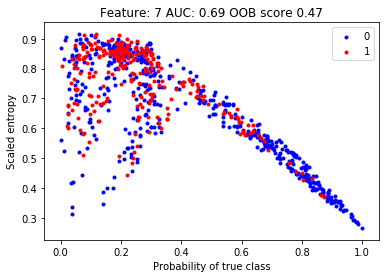

In [459]:
bins=10
results_dict={}
classifier_oob_score = defaultdict(list)
auc_classifier_feature = defaultdict(list)
classifier_dict = {}
oob_scores_dict = {}
model_type="Decision Tree"
results_pd['y']=pd.Series(x['y'].flatten())
oob_scores_list = []
min_leaf_node = int(x['y'].shape[0]*0.04)
for feature_index in range(x['X'].shape[1]):
    y=x['X'][:, feature_index]
    copy=x['X']
    train=np.delete(copy, [feature_index], axis=1)


    y = np.digitize(y, bins=np.histogram(y, bins=bins)[1])
    classifier = RandomForestClassifier(oob_score=True, 
                                  n_estimators=500, bootstrap=True, n_jobs=-1,
                                criterion='entropy', min_samples_leaf=min_leaf_node)
    classifier.fit(train, y)
    oob_score = classifier.oob_score_

    y_map={value: list(set(y.flatten())).index(value)  for value in set(y.flatten())}

    probability_scores=[[classifier.oob_decision_function_[index,:][y_map[element]], element]
     for index, element in enumerate(y.flatten())]

    prob_np=np.array(probability_scores)



    num_classes=np.unique(y).shape[0]
    if num_classes>1:
        max_entropy = np.log(num_classes)
    else:
        max_entropy = 1
        
    entropy = np.array([sum([-value*np.log(value+10**(-8)) for value in ls]) for ls in classifier.oob_decision_function_])/max_entropy

    fpr, tpr, thresholds = metrics.roc_curve(results_pd['y'], entropy, pos_label=1)
    auc_value = metrics.auc(fpr, tpr)
    auc_classifier_feature[feature_index].append(auc_value)
    results_pd["prob_{}".format(feature_index)]=pd.Series(minmax_scale(prob_np[:, 0]))

    results_pd["entropy_{}".format(feature_index)]=pd.Series(entropy)
    plt.scatter(results_pd[results_pd.y!=1]["prob_{}".format(feature_index)], 
                results_pd[results_pd.y!=1]["entropy_{}".format(feature_index)], marker='.', color='b',
                label="0")
    plt.scatter(results_pd[results_pd.y==1]["prob_{}".format(feature_index)], 
                results_pd[results_pd.y==1]["entropy_{}".format(feature_index)],
                marker='.', color='r', label="1")
    plt.legend()
    plt.xlabel('Probability of true class')
    plt.ylabel("Scaled entropy")
    plt.title("Feature: {} AUC: {:.2f} OOB score {:.2f}".format(feature_index, auc_value, oob_score))
    oob_scores_dict[feature_index] = oob_score
    results_dict[feature_index] = results_pd
    plt.show()

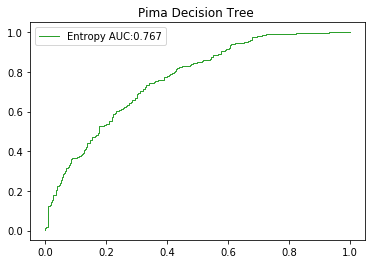

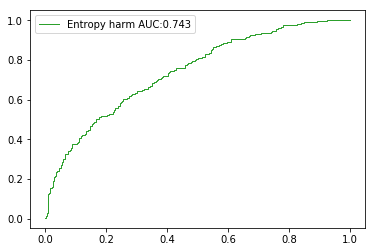

In [460]:
columns_list_entropy=["entropy_{}".format(index) for index in range(x['X'].shape[1])]
plt.title("Pima {} ".format(model_type))
results_pd['entropy_sum']=(results_pd[columns_list_entropy]).sum(axis=1)/x['X'].shape[1]

abs_diff_harmonic=results_pd[columns_list_entropy].apply(np.log).sum(skipna=True, axis=1).replace(-np.inf, -1000).replace(np.inf, 1000)
results_pd['entropy_agg_harmonic_sum']=pd.Series(minmax_scale(abs_diff_harmonic.values))
fpr, tpr, thresholds = metrics.roc_curve(labels, results_pd['entropy_sum'], pos_label=1)
plt.plot(fpr, tpr, lw=1, label="Entropy AUC:{:.3}".format(metrics.auc(fpr, tpr)), color='C{}'.format(2))
plt.legend()
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(labels, results_pd['entropy_agg_harmonic_sum'], pos_label=1)
plt.plot(fpr, tpr, lw=1, label="Entropy harm AUC:{:.3}".format(metrics.auc(fpr, tpr)), color='C{}'.format(2))
plt.legend()
plt.show()